In [100]:
from pathlib import Path
from unidecode import unidecode
import regex as re

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import emoji
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 4000
pd.set_option('display.expand_frame_repr', False)


cwd = !pwd
cwd = Path(str(cwd[0]))
file_name = "murphys_clan_new.txt"
raw_file_path = cwd.parent / "raw_export" / file_name
nlp = English()
tokenizer = Tokenizer(nlp.vocab)


def starts_with_timestamp(line):
    pattern = '\d{2}\/\d{2}\/\d{4}, \d{2}:\d{2} - '
    result = re.match(pattern, line)
    if result:
        return True
    return False

def get_convo_as_list(raw_file_path):
    cleaned_data = []
    with open(raw_file_path, encoding="utf-8") as f:
        message_buffer = []
        f.readline() # Skip first line as never a message.
        while True:
            line = f.readline() 
            if not line:
                break
            line = line.strip()
            if starts_with_timestamp(line):
                if message_buffer:
                    cleaned_data.append("\n".join(message_buffer))
                message_buffer.clear()
                message_buffer.append(line)
            else:
                message_buffer.append(line)
    return cleaned_data

def get_raw_series(raw_text):
    return pd.Series(raw_text)
    
def extract_emojis(string):
    return [char for char in string if char in emoji.UNICODE_EMOJI]

def process_dataframe(raw_series, rename_dict):
    df = raw_series.str.extract('(\d{2}\/\d{2}\/\d{4}, \d{2}:\d{2})?( - .*|.*)')
    df.rename(columns={0 :'datetime', 1 :'other'}, inplace=True)
    df = process_datetime(df)
    df[["sender", "message"]] = df["other"].str.split(": ", n=1, expand=True)
    df.drop("other", inplace=True, axis=1)
    df.dropna(inplace=True)
    clean_sender(df, rename_dict)
    df['tokens'] = df.message.apply(lambda x: tokenizer(x))
    return df

def process_datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y, %H:%M')
    df['hour'] = df['datetime'].dt.strftime('%H').astype('int64')
    return df

def add_stats(df):
    df['word_count'] = df['tokens'].str.len()
    df['letter_count'] = df['message'].apply(lambda s : len(s))
    df['avg_word_length'] = df['letter_count'] / df['word_count']    
    return df
    
def clean_sender(df, rename_dict):
    df['sender'] = df['sender'].str.replace(' - ', '')
    df['sender'].replace(to_replace=rename_dict, inplace=True)
    return df

def process_emoji_df(df):
    df['emoji'] = df.message.apply(extract_emojis)
    df.drop(['message', 'tokens'], axis=1, inplace=True)
    df = df.explode('emoji')
    return df

rename_dict = {'+44 7964 738500':'Mum'}
raw_text = get_convo_as_list(raw_file_path)
raw_series = get_raw_series(raw_text) 
df = process_dataframe(raw_series, rename_dict)
em_df = df.copy()
em_df = process_emoji_df(em_df)
df = add_stats(df)
    

## Time difference between series apply and dataframe apply by row

In [101]:
%timeit tokens = df.message.apply(lambda x: tokenizer(x))

316 ms ± 6.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [102]:
%timeit tokens = df.apply(lambda row: tokenizer(row["message"]), axis=1)

756 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Look see of initial read in method

In [103]:
em_df.sample(20)

,datetime,hour,sender,emoji
6016,2018-02-26 12:04:00,12,Dad,NaN
7354,2018-05-06 11:35:00,11,Calum Pearson,NaN
20260,2021-04-06 20:41:00,20,Dad,NaN
18760,2021-01-24 12:49:00,12,Mum,NaN
1287,2016-12-03 19:46:00,19,Calum Pearson,NaN
11080,2019-05-01 20:29:00,20,Dad,NaN
6226,2018-03-02 11:02:00,11,Rory Pearson,NaN
16858,2020-09-07 18:46:00,18,Calum Pearson,NaN
18704,2021-01-22 19:45:00,19,Rory Pearson,NaN
8722,2018-08-04 11:52:00,11,Calum Pearson,NaN


<AxesSubplot:>

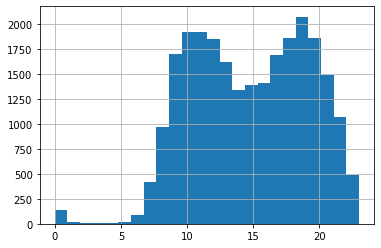

In [104]:
df.hour.hist(bins=24)

In [105]:
df.sender.value_counts()

Calum Pearson    8425
Rory Pearson     7868
Dad              6404
Mum              2606
Name: sender, dtype: int64

<AxesSubplot:>

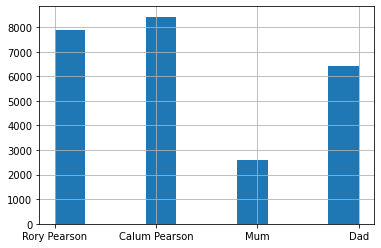

In [106]:
df.sender.hist()

<AxesSubplot:>

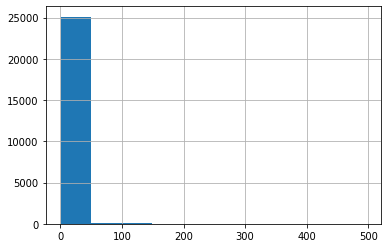

In [107]:
df.avg_word_length.hist()

In [108]:
df[df['message'].str.contains("http")]

,datetime,hour,sender,message,tokens,word_count,letter_count,avg_word_length
16,2016-03-19 18:18:00,18,Rory Pearson,https://youtu.be/ur97Eo3tpso,(https://youtu.be/ur97Eo3tpso),1,28,28.000000
104,2016-06-23 09:15:00,9,Rory Pearson,https://www.goodwood.com/flagship-events/festi...,(https://www.goodwood.com/flagship-events/fest...,1,78,78.000000
124,2016-07-04 09:42:00,9,Dad,http://rcknmwcyct.pw/gaz6s9/x1psi.html?model=G...,(http://rcknmwcyct.pw/gaz6s9/x1psi.html?model=...,1,444,444.000000
219,2016-08-04 11:34:00,11,Calum Pearson,http://www.itv.com/news/anglia/update/2016-08-...,(http://www.itv.com/news/anglia/update/2016-08...,1,117,117.000000
253,2016-08-11 23:40:00,23,Rory Pearson,Rio Olympics 2016: GB's Rose hits first Olympi...,"(Rio, Olympics, 2016:, GB's, Rose, hits, first...",11,106,9.636364
336,2016-08-22 15:02:00,15,Calum Pearson,http://www.helmores.com/properties/bewsley-hil...,(http://www.helmores.com/properties/bewsley-hi...,1,57,57.000000
418,2016-09-01 10:53:00,10,Rory Pearson,Do cycle cameras make the roads any safer? - h...,"(Do, cycle, cameras, make, the, roads, any, sa...",10,88,8.800000
495,2016-09-17 09:54:00,9,Calum Pearson,"Who, What, Why: What made electricity prices s...","(Who,, What,, Why:, What, made, electricity, p...",13,114,8.769231
497,2016-09-19 14:02:00,14,Rory Pearson,http://www.thedailymash.co.uk/news/environment...,(http://www.thedailymash.co.uk/news/environmen...,1,106,106.000000
512,2016-09-23 16:55:00,16,Calum Pearson,Hello. I'm fundraising on JustGiving. Please d...,"(Hello., I'm, fundraising, on, JustGiving., Pl...",16,131,8.187500


Unlikely anyone in a WhatsApp chat is using words over 18 chars in length so assume it to be link and set to np.nan. Majority of links seem to be sent on their own (although not all) so should be alrightish to do.
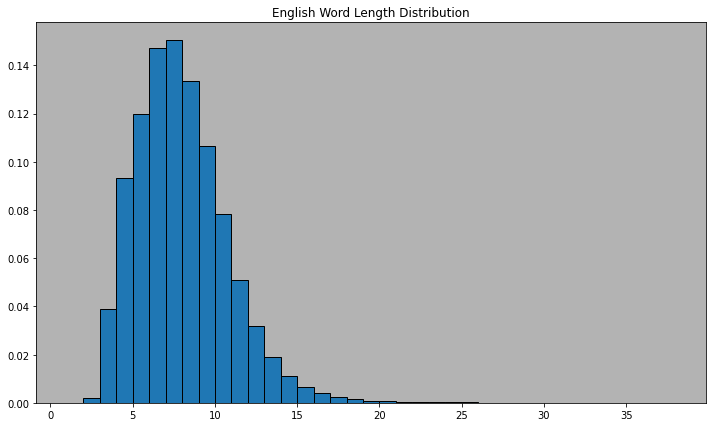

<AxesSubplot:>

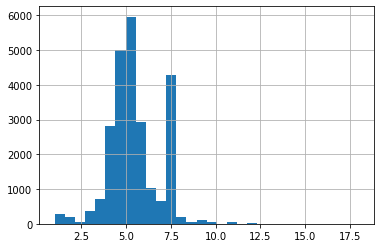

In [109]:
df['avg_word_length'].where(df['avg_word_length'] < 19, np.nan, inplace=True)
df.avg_word_length.hist(bins=30)

In [110]:
df[df['message'].str.contains("http")].count()

datetime           475
hour               475
sender             475
message            475
tokens             475
word_count         475
letter_count       475
avg_word_length     56
dtype: int64

Thought that the spike around 7-8 length words might have been due to links but only 57 of them left after the cull. Have a look at the sentences that have this range.

In [111]:
df[(df['avg_word_length'] > 7) & (df['avg_word_length'] < 9)].sample(15)

,datetime,hour,sender,message,tokens,word_count,letter_count,avg_word_length
17544,2020-11-07 13:04:00,13,Dad,<Media omitted>,"(<Media, omitted>)",2,15,7.500000
11759,2019-06-23 11:26:00,11,Calum Pearson,<Media omitted>,"(<Media, omitted>)",2,15,7.500000
17716,2020-11-26 21:47:00,21,Mum,<Media omitted>,"(<Media, omitted>)",2,15,7.500000
10100,2019-01-31 20:14:00,20,Dad,<Media omitted>,"(<Media, omitted>)",2,15,7.500000
24985,2022-02-21 11:11:00,11,Dad,"Dorset Council. Very impressed. Very polite, e...","(Dorset, Council., Very, impressed., Very, pol...",9,65,7.222222
6528,2018-03-19 08:44:00,8,Calum Pearson,<Media omitted>,"(<Media, omitted>)",2,15,7.500000
17103,2020-10-07 17:44:00,17,Calum Pearson,<Media omitted>,"(<Media, omitted>)",2,15,7.500000
16764,2020-08-30 23:57:00,23,Dad,<Media omitted>,"(<Media, omitted>)",2,15,7.500000
19745,2021-03-11 09:27:00,9,Rory Pearson,<Media omitted>,"(<Media, omitted>)",2,15,7.500000
1339,2016-12-09 14:47:00,14,Rory Pearson,<Media omitted>,"(<Media, omitted>)",2,15,7.500000


In all but a few cases the culprit is `<Media omitted>` messages. They still represent something so don't delete, but set the `word_count`, `letter_count`,	and `avg_word_length`.

In [112]:
df.loc[df['message']=='<Media omitted>',['word_count','letter_count', 'avg_word_length']] = np.nan

### Rerun to see if nomality has resumed.

<AxesSubplot:>

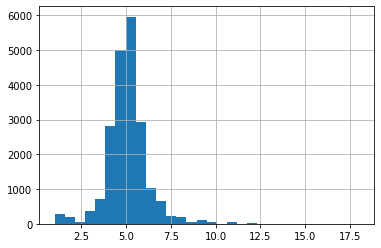

In [113]:
df.avg_word_length.hist(bins=30)

Looks pretty normal now

In [114]:
em_df.groupby(['sender', 'emoji']).size().nlargest(10)

sender         emoji
Mum            🥰        137
Calum Pearson  😂        104
Mum            😘         71
Rory Pearson   😬         38
Mum            🤣         28
Rory Pearson   👀         22
Calum Pearson  🤞         21
               😬         20
Rory Pearson   👌         20
Calum Pearson  ☀         19
dtype: int64

In [115]:
s = em_df.groupby(['sender']).emoji.value_counts().groupby(level=0, group_keys=False).head(3)

In [116]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer=lambda x: x)
counted_values = cv.fit_transform(em_df['emoji'][em_df['emoji'].notnull()]).toarray()
test_df = pd.DataFrame(counted_values, columns=cv.get_feature_names_out())

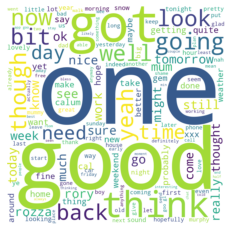

In [117]:
from wordcloud import WordCloud, STOPWORDS
word_series = df.message.copy()

stop_words = ["https", "co", 'xx', "will"] + list(STOPWORDS)
word_series.loc[word_series =='<Media omitted>'] = np.nan
word_series.dropna(inplace=True)
word_series = word_series.str.lower()
words = " ".join(review for review in word_series)
wordcloud = WordCloud(min_word_length=2,
                      max_words=150,
                      stopwords=stop_words,
                      relative_scaling=0.2,
                      width=1200, height=1200,
                      background_color="white").generate(words)

# Display the generated image:
# the matplotlib way:
fig = plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
fig.savefig('fig1.png', dpi=600)

In [118]:
d = pd.Series(WordCloud().process_text(words))
d = d.sort_values(ascending=False)
d = d[100:200]
data = d.to_dict()

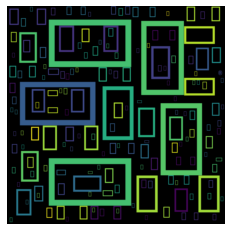

In [119]:
import string
emoji_series = em_df['emoji'].copy()
emoji_series.dropna(inplace=True)
emojis = "|".join(emoji for emoji in emoji_series)
emoji_regex = r"(?:[^|])(?<![\w{ascii_printable}])".format(ascii_printable=string.printable)


font_path = cwd.parent / "fonts" / "Symbola.ttf"
wordcloud = WordCloud(regexp=emoji_regex,
                      width=1200, height=1200,).generate(emojis)
# Display the generated image:
# the matplotlib way:
fig = plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
fig.savefig('emoji.png', dpi=600)


In [120]:
grp = df.groupby(['sender', 'hour']).size()

<AxesSubplot:xlabel='hour'>

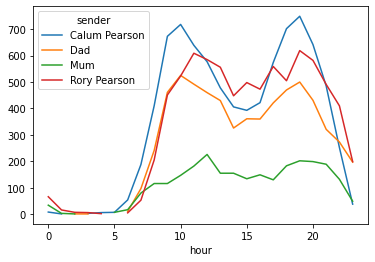

In [121]:
grp.unstack('sender').plot.line()

## Normalise data to get a clearer picture

In [122]:
df2 = df.groupby(['sender', 'hour']).size().reset_index(name='prod_count')
s = df.sender.value_counts()
df2['prod_count'] = df2['prod_count'].div(df2['sender'].map(s))
df2

,sender,hour,prod_count
0,Calum Pearson,0,0.000950
1,Calum Pearson,1,0.000119
2,Calum Pearson,3,0.000356
3,Calum Pearson,4,0.000712
4,Calum Pearson,5,0.000831
5,Calum Pearson,6,0.006409
6,Calum Pearson,7,0.022315
7,Calum Pearson,8,0.048665
8,Calum Pearson,9,0.079881
9,Calum Pearson,10,0.085223


<AxesSubplot:xlabel='hour'>

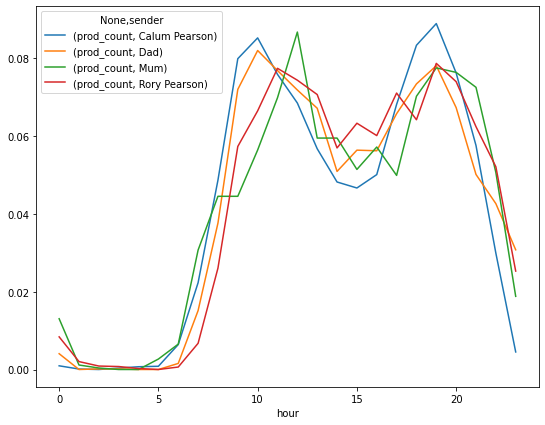

In [123]:
g2 = df2.groupby(['sender', 'hour']).sum()
df3 = g2.unstack('sender')
df3.replace(np.nan, 0, inplace=True)
df3.plot(kind='line', figsize=(9, 7))


<AxesSubplot:xlabel='x1', ylabel='Dad'>

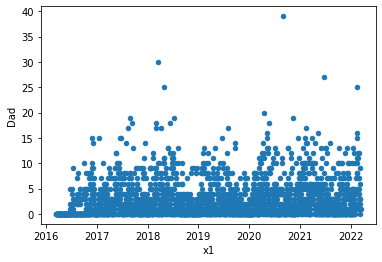

In [184]:
df_time = df.groupby(['sender', df['datetime'].dt.date]).size()
df_time = df_time.unstack('sender').replace(np.nan, 0)
idx = pd.date_range(df_time.index.min(), df_time.index.max())
df_time = df_time.reindex(idx, fill_value=0)


/tmp/ipykernel_17430/872202548.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['x1'], dtype='object', name='sender')
  df_test = df_test.rolling(50).mean()


<AxesSubplot:>

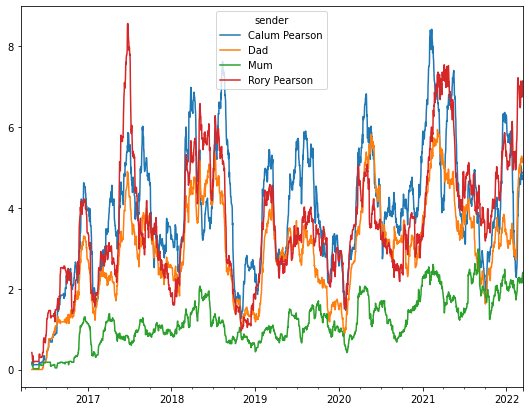

In [196]:
df_test = df_time.copy()
df_test = df_test.rolling(50).mean()
# df_test['x1'] = df_time.index
df_test.plot(figsize=(9, 7))